# Process Shadow Tomography

Process shadow tomography extends the idea of classical shadows from quantum states to quantum processes (or channels). Instead of constructing a classical shadow $\hat{\rho}$ that approximates a quantum state $\rho$, we build a classical shadow $\hat{\Lambda}$ that captures the full behavior of a quantum process $\mathcal{E}$ (which maps input states $\rho_i$ to output states $\rho_f = \mathcal{E}(\rho_i)$).

In our approach, we represent the quantum process $\mathcal{E}$ as a Choi matrix $\Lambda$ via the Choi–Jamiołkowski isomorphism:
$$
\Lambda = \sum_{\xi', \xi} \ket{\xi'}\bra{\xi} \otimes \mathcal{E}\bigl(\ket{\xi'}\bra{\xi}\bigr).
$$
The process shadow $\hat{\Lambda}$ is then constructed from randomized measurements such that its expectation value equals the true Choi matrix:
$$
\mathbb{E}[\hat{\Lambda}] = \Lambda.
$$

This methodology enables us to estimate various properties of the quantum process—such as its fidelity and error rates—without performing full quantum process tomography. The technique has been explored in recent works, for example:
- **Kunjummen et al., Phys. Rev. A 107, 042403 (2023)** [https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042403](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042403)
- **Levy et al., Phys. Rev. Research 2024** [https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029)

In this tutorial, we detail the steps to construct process shadows and demonstrate how they can be used to efficiently characterize and benchmark noisy quantum processes.

In [1]:
using RandomMeas

## Exact Channel Representation

To characterize the quantum process, we first compute the exact Choi matrix. We start by constructing the unnormalized density matrix 
$$
\rho_0 = \left(\sum_{\xi'} \ket{\xi'}^{\otimes 2}\right)\left(\sum_{\xi} \bra{\xi}^{\otimes 2}\right),
$$
which represents a Bell state between two copies of an \(N\)-qubit system. We then evolve this state by applying the quantum channel \(\mathcal{E}\) on one half, obtaining the Choi matrix:
$$
\Lambda = (1 \otimes \mathcal{E})(\rho_0).
$$

In our study, we compare two channels:
- $\mathcal{E}_0$: the ideal quantum channel generated by a perfect quantum circuit,
- $\mathcal{E}$: the quantum channel corresponding to a noisy quantum circuit.

This exact channel representation forms the basis for our process shadow tomography.

In [2]:
N = 2 # number of qubits
depth = 2 # circuit depth

ξ_out = siteinds("Qubit", N;addtags="output") # output indices of the choi matrix
ξ_in = siteinds("Qubit", N;addtags="input") # input indices of the choi matrix

#Create a Bell-State density matrix on two copies of the system
ρ0 = MPO(ξ_out)
for i in 1:N
    ρ0[i] = δ(ξ_in[i],ξ_out[i])*δ(ξ_in[i]',ξ_out[i]')
end

circuit    = random_circuit(ξ_out, depth)
Λ0 = apply(circuit,ρ0,apply_dag=true); # We apply the unitary circuit to the density matrix to one copy (i.e.\ compute  rho = (1 \otimes E_0)(rho_0) )

p  = 0.2*rand(N)
Λ = apply_depo_channel(Λ0,p); # We apply noise to the output density matrix of the ideal circuit (i.e.\ compute (1 \otimes E)(rho_0) )


Our aim is to estimate the process fidelity
$$
\mathcal{F} = \frac{1}{4^N} \langle \Lambda \mid \Lambda_0 \rangle,
$$
where $\langle \cdot \mid \cdot \rangle$ denotes the Hilbert–Schmidt inner product. In this expression, $\Lambda_0$ represents the Choi matrix of the ideal (unitary) quantum channel, while $\Lambda$ is the Choi matrix for the experimentally realized (noisy) channel. This simplified formula holds because the ideal channel is unitary; if it were not, a more complex expression would be required.

In [3]:
F = real(inner(Λ,Λ0)/4^N)
println(" -- Process Fidelity ", F)

 -- Process Fidelity 0.8072537200721512


## Process shadows and fidelity estimation

To construct classical shadows $\hat{\Lambda}$ of a quantum process $\Lambda$, we begin by preparing random initial states, evolving them with the (noisy) circuit, and performing measurements in a random basis. Importantly, the choice of random initial state and random measurement basis are independent.

Specifically, consider a random initial state
$$
U_i^\dagger \ket{0}^{\otimes N},
$$
and suppose that, after applying a random rotation $U_f$, a computational basis measurement yields an outcome bitstring $s$. (Both $U_i$ and $U_f$ are drawn independently from the Haar measure over single-qubit unitaries.) Under these conditions, one can construct the process shadow as [Eq. (B2) in Levy et al., Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029):
$$
\hat{\Lambda} = 2^N \, \mathcal{M}^{-1}\!\Bigl( \bigl[ U_i^\dagger \ket{0}^{\otimes N}\bra{0} U_i \bigr] \Bigr)^T \otimes \mathcal{M}^{-1}\!\Bigl( U_f^\dagger \ket{s}^{\otimes N}\bra{s} U_f \Bigr).
$$

To reduce statistical errors, we further incorporate our knowledge of the ideal process $\Lambda_0$ using the concept of common randomized measurements (CRM) [Vermersch et al., PRX Quantum 2024](https://doi.org/10.1103/PRXQuantum.5.010352). In this approach, we construct CRM process shadows as
$$
\hat{\Lambda}_{\mathrm{CRM}} = \hat{\Lambda} - \hat{\Lambda}_0 + \Lambda_0,
$$
where $\hat{\Lambda}_0$ is a classical shadow of the Choi matrix $\Lambda_0$ corresponding to the ideal (unitary) channel, constructed on a classical computer using the same random initial states and measurement bases as in the experiment. When $\Lambda \approx \Lambda_0$ (i.e. under weak noise), the strong correlation between $\hat{\Lambda}$ and $\hat{\Lambda}_0$ leads to a significant reduction in statistical errors. Importantly, regardless of the noise level, $\hat{\Lambda}_{\mathrm{CRM}}$ is an unbiased estimator of the true Choi matrix $\Lambda$.

In [4]:
ITensors.disable_warn_order()

nu = 1000
NM = 1000
states = ["Dn" for n in 1:N]
ψ_initial = MPS(ComplexF64,ξ_in,states)
ψ  = MPS(ComplexF64,ξ_out,states)
ρ = outer(ψ',ψ)
data = zeros(Int,(NM,N))
Λs = ITensor(vcat(ξ_out,ξ_out',ξ_in,ξ_in'))
Fs = zeros(Float64,nu)

Λs_CRM = ITensor(vcat(ξ_out,ξ_out',ξ_in,ξ_in'))
Fs_CRM = zeros(Float64,nu)

@showprogress dt=1 for r in 1:nu   
        measurement_setting_initial = LocalUnitaryMeasurementSetting(N;site_indices=ξ_in)
        measurement_setting_final = LocalUnitaryMeasurementSetting(N;site_indices=ξ_out)

        #Build shadow for the initial state. 
        measurement_initial_results = 2*ones(Int,1, N) # We consider the state |0><0>, i.e the index s=2 in ITensor.
        measurement_data_initial = MeasurementData(measurement_initial_results; measurement_setting=measurement_setting_initial)
        shadow_initial = DenseShadow(measurement_data_initial)
        shadow_initial = partial_transpose(shadow_initial,collect(1:N)) #Final transposition

        #Build shadow for the initial state. 
        uid = [swapinds(dag(measurement_setting_initial.basis_transformation[i]),ξ_in[i],ξ_in[i]')*δ(ξ_in[i],ξ_out[i])*δ(ξ_in'[i],ξ_out'[i]) for i in 1:N] #We compute u_i^\dag
        ρ1 = apply(uid,ρ,apply_dag=true)
        ρ2 = apply(circuit,ρ1,apply_dag=true)
        ρ3 = apply_depo_channel(ρ2,p)
        measurement_data = MeasurementData(ρ3,NM,measurement_setting_final)
        shadow_final = DenseShadow(measurement_data)
     
        #Form process shadow
        Λt = 2^N*shadow_initial.shadow_data*shadow_final.shadow_data
        Λs += Λt

        Fs[r] = real(inner(Λs,flatten(Λ0))/2^(2*N))/r
        
        ## CRM part ##
        measurement_probability = MeasurementProbability(ρ2,measurement_setting_final)
        shadow_final_ideal = DenseShadow(measurement_probability)
        Λt_CRM = Λt-2^N*shadow_initial.shadow_data*shadow_final_ideal.shadow_data+flatten(Λ0)
        Λs_CRM += Λt_CRM
        Fs_CRM[r] = real(inner(Λs_CRM,flatten(Λ0))/2^(2*N))/r
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


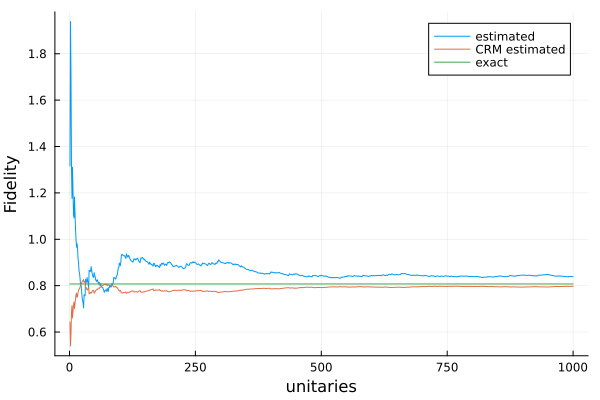

In [5]:
using Plots
plot(1:nu,Fs,label="estimated")
plot!(1:nu,Fs_CRM,label="CRM estimated")
plot!(1:nu,F*ones(nu),label="exact")

ylabel!("Fidelity")
xlabel!("unitaries")